# Convolutional Neural Networks for Text Classification

Github: https://github.com/dennybritz/cnn-text-classification-tf

Paper:  https://arxiv.org/pdf/1408.5882.pdf

## Task Introduction

### Input

A sentence in the format of a string from the movie comments.

Eg. 1:  "a thoughtful , provocative , insistently humanizing film . "

Eg. 2:  "the effort is sincere and the results are honest , but the film is so bleak that it's hardly watchable ."

### Output

A binary sentiment classification result of the input sentence, 0 indicates negative and 1 indicates positive.

Eg. 1:  1 (positive)

Eg. 2:  0 (negative)

### Data Helpers

In [1]:
import numpy as np
import re


def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


def load_data_and_labels(positive_data_file, negative_data_file):
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files
    positive_examples = list(open(positive_data_file, "r", encoding='utf-8').readlines())
    positive_examples = [s.strip() for s in positive_examples]
    negative_examples = list(open(negative_data_file, "r", encoding='utf-8').readlines())
    negative_examples = [s.strip() for s in negative_examples]
    # Split by words
    x_text = positive_examples + negative_examples
    x_text = [clean_str(sent) for sent in x_text]
    # Generate labels
    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return [x_text, y]


def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]


## Model Description

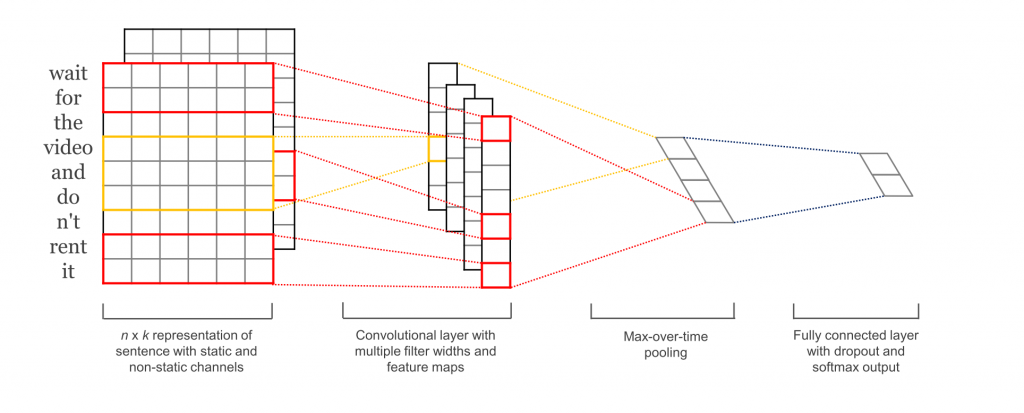

### Embedding Lookup Layer (Line 22 - 28)

You may use Word2vec or GloVe to replace the random initialization.

Tunable hyper parameters:

    embedding_dim

### Convolution Layer (Line 34 - 45)

You may try different nonlinearity other than relu.

Tunable hyper parameters:

    filter_sizes
    num_filters
    
### Max Pooling Layer (Line 46 - 53)

### Fully Connected Layer with Dropout and Softmax Output (Line 60 - 79)

Softmax function:

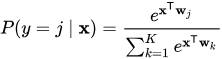

Cross Entropy Loss:

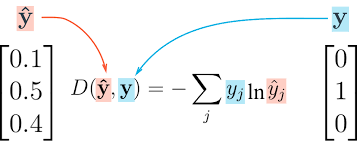

Tunable hyper parameters:

    dropout_keep_prob (only for training)
    l2_reg_lambda

All the tunable hyper parameters can be tuned at the third code block (train).

In [2]:
import tensorflow as tf
import numpy as np


class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(
                tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

### Train

Some tunable training hyper parameters which may influence the results:

    batch_size
    num_epochs
    optimizer (line 94)

All the tunable hyper parameters can be tuned here.

In [3]:
#! /usr/bin/env python

import tensorflow as tf
import numpy as np
import os
import time
import datetime
from tensorflow.contrib import learn

# Parameters
# ==================================================

# Data loading params
tf.flags.DEFINE_float("dev_sample_percentage", .1, "Percentage of the training data to use for validation")
tf.flags.DEFINE_string("positive_data_file", "./data/rt-polaritydata/rt-polarity.pos", "Data source for the positive data.")
tf.flags.DEFINE_string("negative_data_file", "./data/rt-polaritydata/rt-polarity.neg", "Data source for the negative data.")

# Model Hyperparameters
tf.flags.DEFINE_integer("embedding_dim", 128, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_string("filter_sizes", "3,4,5", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 128, "Number of filters per filter size (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.0, "L2 regularization lambda (default: 0.0)")

# Training parameters
tf.flags.DEFINE_integer("batch_size", 64, "Batch Size (default: 64)")
tf.flags.DEFINE_integer("num_epochs", 20, "Number of training epochs (default: 20)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

FLAGS = tf.flags.FLAGS
# FLAGS._parse_flags()
# print("\nParameters:")
# for attr, value in sorted(FLAGS.__flags.items()):
#     print("{}={}".format(attr.upper(), value))
# print("")

def preprocess():
    # Data Preparation
    # ==================================================

    # Load data
    print("Loading data...")
    x_text, y = load_data_and_labels(FLAGS.positive_data_file, FLAGS.negative_data_file)

    # Build vocabulary
    max_document_length = max([len(x.split(" ")) for x in x_text])
    vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
    x = np.array(list(vocab_processor.fit_transform(x_text)))

    # Randomly shuffle data
    np.random.seed(10)
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x_shuffled = x[shuffle_indices]
    y_shuffled = y[shuffle_indices]

    # Split train/test set
    # TODO: This is very crude, should use cross-validation
    dev_sample_index = -1 * int(FLAGS.dev_sample_percentage * float(len(y)))
    x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
    y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]

    del x, y, x_shuffled, y_shuffled

    print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
    print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))
    return x_train, y_train, vocab_processor, x_dev, y_dev

def train(x_train, y_train, vocab_processor, x_dev, y_dev):
    # Training
    # ==================================================

    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=FLAGS.allow_soft_placement,
          log_device_placement=FLAGS.log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=FLAGS.embedding_dim,
                filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
                num_filters=FLAGS.num_filters,
                l2_reg_lambda=FLAGS.l2_reg_lambda)

            # Define Training procedure
            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(1e-3)
            grads_and_vars = optimizer.compute_gradients(cnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

            # Keep track of gradient values and sparsity (optional)
            grad_summaries = []
            for g, v in grads_and_vars:
                if g is not None:
                    grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                    sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                    grad_summaries.append(grad_hist_summary)
                    grad_summaries.append(sparsity_summary)
            grad_summaries_merged = tf.summary.merge(grad_summaries)

            # Output directory for models and summaries
            timestamp = str(int(time.time()))
            out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
            print("Writing to {}\n".format(out_dir))

            # Summaries for loss and accuracy
            loss_summary = tf.summary.scalar("loss", cnn.loss)
            acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

            # Train Summaries
            train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
            train_summary_dir = os.path.join(out_dir, "summaries", "train")
            train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

            # Dev summaries
            dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
            dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
            dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

            # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

            # Write vocabulary
            vocab_processor.save(os.path.join(out_dir, "vocab"))

            # Initialize all variables
            sess.run(tf.global_variables_initializer())

            def train_step(x_batch, y_batch):
                """
                A single training step
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: FLAGS.dropout_keep_prob
                }
                _, step, summaries, loss, accuracy = sess.run(
                    [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                train_summary_writer.add_summary(summaries, step)

            def dev_step(x_batch, y_batch, writer=None):
                """
                Evaluates model on a dev set
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: 1.0
                }
                step, summaries, loss, accuracy = sess.run(
                    [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if writer:
                    writer.add_summary(summaries, step)

            # Generate batches
            batches = batch_iter(
                list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
            # Training loop. For each batch...
            for batch in batches:
                x_batch, y_batch = zip(*batch)
                train_step(x_batch, y_batch)
                current_step = tf.train.global_step(sess, global_step)
                if current_step % FLAGS.evaluate_every == 0:
                    print("\nEvaluation:")
                    dev_step(x_dev, y_dev, writer=dev_summary_writer)
                    print("")
                if current_step % FLAGS.checkpoint_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                    print("Saved model checkpoint to {}\n".format(path))

def main(argv=None):
    x_train, y_train, vocab_processor, x_dev, y_dev = preprocess()
    train(x_train, y_train, vocab_processor, x_dev, y_dev)

if __name__ == '__main__':
    tf.app.run()

Loading data...
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Vocabulary Size: 18758
Train/Dev split: 9596/1066
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using co

2018-11-29T07:18:21.340762: step 78, loss 2.08931, acc 0.40625
2018-11-29T07:18:21.437514: step 79, loss 1.44871, acc 0.5625
2018-11-29T07:18:21.525876: step 80, loss 1.08086, acc 0.578125
2018-11-29T07:18:21.622989: step 81, loss 1.8954, acc 0.46875
2018-11-29T07:18:21.722985: step 82, loss 1.26641, acc 0.53125
2018-11-29T07:18:21.828997: step 83, loss 1.4734, acc 0.5
2018-11-29T07:18:21.928491: step 84, loss 1.48923, acc 0.578125
2018-11-29T07:18:22.027280: step 85, loss 1.65687, acc 0.515625
2018-11-29T07:18:22.117204: step 86, loss 1.38586, acc 0.46875
2018-11-29T07:18:22.213650: step 87, loss 1.6278, acc 0.4375
2018-11-29T07:18:22.310337: step 88, loss 1.8476, acc 0.484375
2018-11-29T07:18:22.409136: step 89, loss 1.21161, acc 0.625
2018-11-29T07:18:22.512212: step 90, loss 1.27565, acc 0.578125
2018-11-29T07:18:22.613230: step 91, loss 1.46849, acc 0.5
2018-11-29T07:18:22.709909: step 92, loss 1.23907, acc 0.59375
2018-11-29T07:18:22.806501: step 93, loss 1.03937, acc 0.625
2018-

2018-11-29T07:18:33.832915: step 203, loss 1.02027, acc 0.59375
2018-11-29T07:18:33.931539: step 204, loss 1.03768, acc 0.5
2018-11-29T07:18:34.026641: step 205, loss 0.860905, acc 0.625
2018-11-29T07:18:34.121959: step 206, loss 0.93065, acc 0.546875
2018-11-29T07:18:34.220379: step 207, loss 1.0639, acc 0.546875
2018-11-29T07:18:34.317172: step 208, loss 0.861696, acc 0.65625
2018-11-29T07:18:34.428620: step 209, loss 0.741486, acc 0.625
2018-11-29T07:18:34.522437: step 210, loss 0.897951, acc 0.5625
2018-11-29T07:18:34.618215: step 211, loss 0.747267, acc 0.625
2018-11-29T07:18:34.715931: step 212, loss 1.08191, acc 0.59375
2018-11-29T07:18:34.814355: step 213, loss 0.91998, acc 0.546875
2018-11-29T07:18:34.911419: step 214, loss 0.796145, acc 0.71875
2018-11-29T07:18:34.983230: step 215, loss 0.873789, acc 0.59375
2018-11-29T07:18:35.078175: step 216, loss 0.692656, acc 0.71875
2018-11-29T07:18:35.161255: step 217, loss 1.19555, acc 0.59375
2018-11-29T07:18:35.257091: step 218, los

2018-11-29T07:18:45.837242: step 328, loss 0.606035, acc 0.671875
2018-11-29T07:18:45.934557: step 329, loss 0.862107, acc 0.609375
2018-11-29T07:18:46.032795: step 330, loss 0.582902, acc 0.71875
2018-11-29T07:18:46.127681: step 331, loss 0.742272, acc 0.609375
2018-11-29T07:18:46.221189: step 332, loss 0.698345, acc 0.640625
2018-11-29T07:18:46.304994: step 333, loss 0.716901, acc 0.5625
2018-11-29T07:18:46.398169: step 334, loss 0.507123, acc 0.75
2018-11-29T07:18:46.488733: step 335, loss 0.529325, acc 0.703125
2018-11-29T07:18:46.582000: step 336, loss 0.674116, acc 0.6875
2018-11-29T07:18:46.675019: step 337, loss 0.787793, acc 0.546875
2018-11-29T07:18:46.768242: step 338, loss 0.780383, acc 0.65625
2018-11-29T07:18:46.862777: step 339, loss 0.698024, acc 0.6875
2018-11-29T07:18:46.957002: step 340, loss 0.666387, acc 0.734375
2018-11-29T07:18:47.051721: step 341, loss 0.676516, acc 0.609375
2018-11-29T07:18:47.147873: step 342, loss 0.661333, acc 0.609375
2018-11-29T07:18:47.23

2018-11-29T07:18:57.848066: step 454, loss 0.536671, acc 0.765625
2018-11-29T07:18:57.939320: step 455, loss 0.52769, acc 0.796875
2018-11-29T07:18:58.031106: step 456, loss 0.621877, acc 0.6875
2018-11-29T07:18:58.099743: step 457, loss 0.651817, acc 0.640625
2018-11-29T07:18:58.185962: step 458, loss 0.460833, acc 0.796875
2018-11-29T07:18:58.278226: step 459, loss 0.553637, acc 0.71875
2018-11-29T07:18:58.369540: step 460, loss 0.595848, acc 0.6875
2018-11-29T07:18:58.444779: step 461, loss 0.59906, acc 0.703125
2018-11-29T07:18:58.539963: step 462, loss 0.662469, acc 0.609375
2018-11-29T07:18:58.636492: step 463, loss 0.494385, acc 0.71875
2018-11-29T07:18:58.731396: step 464, loss 0.506536, acc 0.78125
2018-11-29T07:18:58.827767: step 465, loss 0.476092, acc 0.734375
2018-11-29T07:18:58.915670: step 466, loss 0.53418, acc 0.671875
2018-11-29T07:18:59.008154: step 467, loss 0.611973, acc 0.640625
2018-11-29T07:18:59.101547: step 468, loss 0.524919, acc 0.765625
2018-11-29T07:18:59.

2018-11-29T07:19:09.756014: step 580, loss 0.60844, acc 0.734375
2018-11-29T07:19:09.850633: step 581, loss 0.627226, acc 0.671875
2018-11-29T07:19:09.948307: step 582, loss 0.597094, acc 0.671875
2018-11-29T07:19:10.039312: step 583, loss 0.582768, acc 0.734375
2018-11-29T07:19:10.135909: step 584, loss 0.523731, acc 0.75
2018-11-29T07:19:10.230220: step 585, loss 0.645974, acc 0.609375
2018-11-29T07:19:10.302192: step 586, loss 0.509417, acc 0.8125
2018-11-29T07:19:10.398606: step 587, loss 0.452332, acc 0.796875
2018-11-29T07:19:10.486272: step 588, loss 0.507668, acc 0.75
2018-11-29T07:19:10.582811: step 589, loss 0.472369, acc 0.796875
2018-11-29T07:19:10.683566: step 590, loss 0.608282, acc 0.671875
2018-11-29T07:19:10.755213: step 591, loss 0.69141, acc 0.625
2018-11-29T07:19:10.832411: step 592, loss 0.465141, acc 0.78125
2018-11-29T07:19:10.919209: step 593, loss 0.528539, acc 0.703125
2018-11-29T07:19:11.002255: step 594, loss 0.568226, acc 0.671875
2018-11-29T07:19:11.091203

2018-11-29T07:19:21.646984: step 703, loss 0.809335, acc 0.609375
2018-11-29T07:19:21.745970: step 704, loss 0.592804, acc 0.765625
2018-11-29T07:19:21.839161: step 705, loss 0.493906, acc 0.796875
2018-11-29T07:19:21.934490: step 706, loss 0.60896, acc 0.6875
2018-11-29T07:19:22.024004: step 707, loss 0.555199, acc 0.765625
2018-11-29T07:19:22.118220: step 708, loss 0.434335, acc 0.8125
2018-11-29T07:19:22.222848: step 709, loss 0.559008, acc 0.765625
2018-11-29T07:19:22.314687: step 710, loss 0.608823, acc 0.625
2018-11-29T07:19:22.408081: step 711, loss 0.507159, acc 0.71875
2018-11-29T07:19:22.485439: step 712, loss 0.538553, acc 0.765625
2018-11-29T07:19:22.583383: step 713, loss 0.469595, acc 0.765625
2018-11-29T07:19:22.680361: step 714, loss 0.460348, acc 0.796875
2018-11-29T07:19:22.757123: step 715, loss 0.464197, acc 0.734375
2018-11-29T07:19:22.852216: step 716, loss 0.615933, acc 0.71875
2018-11-29T07:19:22.952446: step 717, loss 0.448708, acc 0.859375
2018-11-29T07:19:23.

SystemExit: 

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Evaluation

You can run directly to use the whole dataset for evaluation, or you may split a piece from the training dataset for testing.

Before evaluation, you should modify the checkpoint directory in Line 15. The run id (10 digits) can be found from the training logs above.

In [4]:
#! /usr/bin/env python

import tensorflow as tf
import numpy as np
import os
import time
import datetime
from tensorflow.contrib import learn
import csv

# Parameters
# ==================================================

# Eval Parameters
tf.flags.DEFINE_string("checkpoint_dir", "./runs/1543475893/checkpoints/", "Checkpoint directory from training run")
tf.flags.DEFINE_boolean("eval_train", True, "Evaluate on all training data")


FLAGS = tf.flags.FLAGS
# FLAGS._parse_flags()
# print("\nParameters:")
# for attr, value in sorted(FLAGS.__flags.items()):
#     print("{}={}".format(attr.upper(), value))
# print("")

# CHANGE THIS: Load data. Load your own data here
if FLAGS.eval_train:
    x_raw, y_test = load_data_and_labels(FLAGS.positive_data_file, FLAGS.negative_data_file)
    y_test = np.argmax(y_test, axis=1)
else:
    x_raw = ["a masterpiece four years in the making", "everything is off."]
    y_test = [1, 0]

# Map data into vocabulary
vocab_path = os.path.join(FLAGS.checkpoint_dir, "..", "vocab")
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)
x_test = np.array(list(vocab_processor.transform(x_raw)))

print("\nEvaluating...\n")

# Evaluation
# ==================================================
checkpoint_file = tf.train.latest_checkpoint(FLAGS.checkpoint_dir)
graph = tf.Graph()
with graph.as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=FLAGS.allow_soft_placement,
      log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        # Load the saved meta graph and restore variables
        saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
        saver.restore(sess, checkpoint_file)

        # Get the placeholders from the graph by name
        input_x = graph.get_operation_by_name("input_x").outputs[0]
        # input_y = graph.get_operation_by_name("input_y").outputs[0]
        dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]

        # Tensors we want to evaluate
        predictions = graph.get_operation_by_name("output/predictions").outputs[0]

        # Generate batches for one epoch
        batches = batch_iter(list(x_test), FLAGS.batch_size, 1, shuffle=False)

        # Collect the predictions here
        all_predictions = []

        for x_test_batch in batches:
            batch_predictions = sess.run(predictions, {input_x: x_test_batch, dropout_keep_prob: 1.0})
            all_predictions = np.concatenate([all_predictions, batch_predictions])

# Print accuracy if y_test is defined
if y_test is not None:
    correct_predictions = float(sum(all_predictions == y_test))
    print("Total number of test examples: {}".format(len(y_test)))
    print("Accuracy: {:g}".format(correct_predictions/float(len(y_test))))

# Save the evaluation to a csv
predictions_human_readable = np.column_stack((np.array(x_raw), all_predictions))
out_path = os.path.join(FLAGS.checkpoint_dir, "..", "prediction.csv")
print("Saving evaluation to {0}".format(out_path))
with open(out_path, 'w') as f:
    csv.writer(f).writerows(predictions_human_readable)


Evaluating...

INFO:tensorflow:Restoring parameters from /notebooks/CNN_and_RNN/runs/1543475893/checkpoints/model-700
Total number of test examples: 10662
Accuracy: 0.855468
Saving evaluation to ./runs/1543475893/checkpoints/../prediction.csv
